In [3]:
import torch

# Parameters

In [ ]:
BATCH_SIZE = 5
N_EPOCHS = 10
LEARNING_RATE = 1e-3 # this equals to 0.001
WEIGHT_DECAY = 1e-3 # this equals to 0.001

# 1. Dataloading

A quick introduction to torch Tensor objects:

Reference: https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html

In [9]:
a_tensor = torch.rand(2, 3, requires_grad=True)
a_tensor + 1

tensor([[1.1709, 1.5693, 1.7678],
        [1.5708, 1.1218, 1.7808]], grad_fn=<AddBackward0>)

Notice something different than a good old numpy arrays? Tensors used in training should be attached to gradient function (grad_fn) that is responsible for each of the backward calculations (i.e., backpropagation steps). That will be important in the training (Section 3). These gradient functions basically used to keep track of whatever happens to the tensors and that creates a tree-like structure, and this tree is called 'gradient tree'. Something that looks like this:

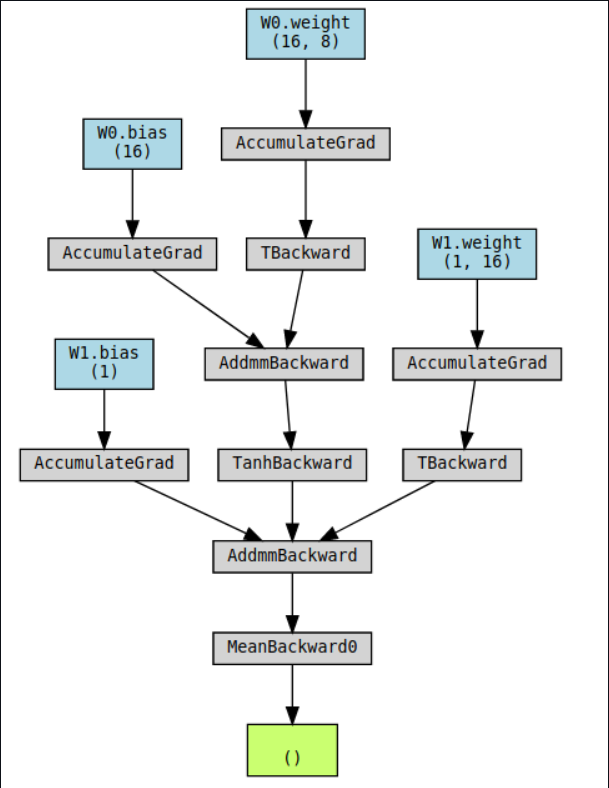

Another commonly used property of the torch tensors is that you can move them between GPU and CPU memory ! Lets first check if you have a GPU available for torch:

In [10]:
torch.cuda.is_available()

True

If you have an error on that line, that would probably because of your torch installation is not a CUDA-supported installation. CUDA is a GPU-compiler that is also pytorch using in its backend to enable it for calculations. If the above line returned True, you can also run:

In [19]:
device = torch.device("cuda")
a_tensor = torch.rand(2, 3, requires_grad=True, device=device)
a_tensor

tensor([[0.7543, 0.5672, 0.9851],
        [0.7372, 0.4523, 0.1890]], device='cuda:0', requires_grad=True)

Above we created a tensor directly in your GPU memory. But also, we can move it to CPU memory (i.e., RAM) and again back to GPU:

In [21]:
a_tensor = a_tensor.cpu()
print(a_tensor)
a_tensor = a_tensor.to(device)
print(a_tensor)

tensor([[0.7543, 0.5672, 0.9851],
        [0.7372, 0.4523, 0.1890]], grad_fn=<ToCopyBackward0>)
tensor([[0.7543, 0.5672, 0.9851],
        [0.7372, 0.4523, 0.1890]], device='cuda:0', grad_fn=<ToCopyBackward0>)


In [ ]:
from torch.utils.data import DataLoader, default_collate

A quick introduction to torch DataLoader and Dataset objects:

Reference: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Extra: an introduction to batch collating:

In [ ]:
tr_dataset = 
tr_dataloader = DataLoader(
    tr_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=default_collate,
)

Lets try out how the data is iterated !

In [ ]:
for image, label in tr_dataloader:
    print(image.shape)
    print(label.shape)

# 2. Model Design

In [ ]:
from torch.nn import Module, Sequential, Linear, ReLU
from torch import Tensor # Only for type-annotations

Layers: BatchNorm, ReLU, Linear layers

In [ ]:
class ImageClassifier(Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        return x

# 3. Training: optimizers and backpropagation

First, lets pick an optimizer and loss function:

In [ ]:
# Define a model:
model = ImageClassifier()

# Define loss:
loss_fn = torch.nn.CrossEntropyLoss()

# Define the optimizer, you need to attach your model(s) parameters
# to an optimizer object that will be responsible for updating your model.
optimizer = torch.optim.AdamW(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

Note that PyTorch has 2 different Adam optimizers, Adam is ... and AdamW is ...

Next, we should define a validation dataset:

In [ ]:
val_dataset = 
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    collate_fn=default_collate,
)

Now we can run the training loop:

In [ ]:
for epoch in range(N_EPOCHS):
    tr_losses = []
    for input_data, target_data in tr_dataloader:
        pred_data = model(input_data)
        tr_loss = loss_fn(pred_data, target_data)

        # First step is to clear the calculated gradients from the previous iteration.
        optimizer.zero_grad()

        # Loss should be 1-value tensor and is a leaf in the gradient tree,
        # Based on the gradient functions attached to the tensors (grad_fn), automatic
        # backpropagation will calculate all gradients in the background.
        tr_loss.backward()

        # Optimizer object is responsible for updating model weights and biases,
        # after the gradients are calculated.
        optimizer.step()

        # tensor.detach() function breaks the gradient tree and returns the tensor only including the data !
        # Thats why you are only allowed to do that after you finish the gradient calculations.
        tr_losses.append(tr_loss.detach())
    
    # tensor.item() returns the one and only attached value here: e.g., tensor((0.00135)) -> 0.00135
    avg_tr_loss = torch.stack(tr_losses).mean().item()

    # After a successful training iteration, we can run a validation loop to monitor model's performance:
    # Since there will be no backpropagation on the validation step, it is unnecessary to store gradients.
    # Therefore we use torch.no_grad to disable all gradient functions during validation for memory efficiency.
    with torch.no_grad():
        val_losses = []
        for input_data, target_data in val_dataloader:
            pred_data = model(input_data)
            val_loss = loss_fn(pred_data, target_data)
            val_losses.append(val_loss.detach())
        avg_val_loss = torch.stack(val_losses).mean().item()

    print(f"Epoch: {epoch}/{N_EPOCHS}, Avg.Tr.Loss: {avg_tr_loss}, Avg.Val.Loss: {avg_val_loss}")

# 4. Testing and evaluation

It is crucial that your testing set is completely disjoint from your training and validation sets, plus it should have the correct representation of the use cases of your model in real life.

In [ ]:
test_dataset = 
# Collect test results one by one (no-batch), because they will be used to calculate metrics.
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    collate_fn=default_collate,
)

Testing loop:

In [ ]:
with torch.no_grad():
    test_preds = []
    test_logits = []
    test_labels = []
    for input_data, target_data in test_dataloader:
        pred_data = model(input_data)
        test_logits.append(test_logits)
        pred_class = torch.argmax(test_logits)
        test_preds.append(pred_class)
        test_labels.append(target_data)


Here lets take a look at the basic classification metrics: accuracy and f1-score:

We need to visualize our results for better interpretation:

In [24]:
import matplotlib.pyplot as plt

Then we can plot a ROC-AUC curve to investigate the model confidence on its predictions.

Lastly, the multi-class confusion matrix is crucial to see the model behaviour.

# 5. Model inference

Now use your model in production ! Dont forget to apply the preprocessing steps if there is any.